# PyTorch Experiment Tracking

## What is experiment tracking?

If you're running lots of different experiments, **experiment tracking helps you figure out what works and what doesn't**.

## Why track experiments?

However, as the number of experiments you run starts to increase, this naive way of tracking could get out of hand.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-experiment-tracking-can-get-out-of-hand.png" alt="experiment tracking can get out of hand, many different experiments with different names" width=900/>

*After building a few models and tracking their results, you'll start to notice how quickly it can get out of hand.*

## Different ways to track machine learning experiments 

There are as many different ways to track machine learning experiments as there are experiments to run.

This table covers a few.

| **Method** | **Setup** | **Pros** | **Cons** | **Cost** |
| ----- | ----- | ----- | ----- | ----- |
| Python dictionaries, CSV files, print outs | None | Easy to setup, runs in pure Python | Hard to keep track of large numbers of experiments | Free |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) | Minimal, install [`tensorboard`](https://pypi.org/project/tensorboard/) | Extensions built into PyTorch, widely recognized and used, easily scales. | User-experience not as nice as other options. | Free |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Minimal, install [`wandb`](https://docs.wandb.ai/quickstart), make an account | Incredible user experience, make experiments public, tracks almost anything. | Requires external resource outside of PyTorch. | Free for personal use | 
| [MLFlow](https://mlflow.org/) | Minimal, install `mlflow` and starting tracking | Fully open-source MLOps lifecycle management, many integrations. | Little bit harder to setup a remote tracking server than other services. | Free | 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-different-places-to-track-experiments.png" alt="various places to track machine learning experiments" width=900/>

## Setup

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0.dev20220709
torchvision version: 0.14.0.dev20220709


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from src import data_setup, engine

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    %pip install -q torchinfo
    from torchinfo import summary

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Create a helper function to set seeds

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

#### Create Datasets and DataLoaders

In [10]:
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

In [11]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x21bf581b6d0>,
 ['pizza', 'steak', 'sushi'])

#### Create DataLoaders using automatically created transforms

In [21]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32,
    num_workers=0
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x21b852a5a60>,
 ['pizza', 'steak', 'sushi'])

#### Getting a pretrained model, freezing the base layers and changing the classifier head

Before we run and track multiple modelling experiments, let's see what it's like to run and track a single one.

And since our data is ready, the next thing we'll need is a model.

Let's download the pretrained weights for a `torchvision.models.efficientnet_b0()` model and prepare it for use with our own data.

In [13]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

In [14]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

Base layers frozen, classifier head changed, let's get a summary of our model with `torchinfo.summary()`.

In [15]:
from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-output-of-torchinfo-summary.png" alt="output of torchinfo.summary() when passed our model when base layers are frozen and classifier head is updated" width=900/>

*Output of `torchinfo.summary()` with our feature extractor EffNetB0 model, notice how the base layers are frozen (not trainable) and the output layers are customized to our own problem.*

#### Train model and track results

In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Adjust `train()` function to track results with `SummaryWriter()`

We can use PyTorch's [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html) class to save various parts of our model's training progress to file.

By default, the `SummaryWriter()` class saves various information about our model to a file set by the `log_dir` parameter. 

The default location for `log_dir` is under `runs/CURRENT_DATETIME_HOSTNAME`, where the `HOSTNAME` is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the `SummaryWriter()` are saved in [TensorBoard format](https://www.tensorflow.org/tensorboard/).

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default `SummaryWriter()` instance.

In [18]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

Now to use the writer, we could write a new training loop or we could adjust the existing `train()` function we created.

Specifically, we'll add the ability for our `train()` function to log our model's training and test loss and accuracy values.

We can do this with [`writer.add_scalars(main_tag, tag_scalar_dict)`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_scalars), where:
* `main_tag` (string) - the name for the scalars being tracked (e.g. "Accuracy")
* `tag_scalar_dict` (dict) - a dictionary of the values being tracked (e.g. `{"train_loss": 0.3454}`)
    * > **Note:** The method is called `add_scalars()` because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call `writer.close()` to tell the `writer` to stop looking for values to track.

To start modifying `train()` we'll also import `train_step()` and `test_step()` from [`engine.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py).

> **Note:** You can track information about your model almost anywhere in your code. But quite often experiments will be tracked *while* a model is training (inside a training/testing loop).
>
> The `torch.utils.tensorboard.SummaryWriter()` class also has many different methods to track different things about your model/data, such as [`add_graph()`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_graph) which tracks the computation graph of your model. For more options, [check the `SummaryWriter()` documentation](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter).

In [19]:
from typing import Dict, List
from tqdm.auto import tqdm

from src.engine import train_step, test_step

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

##### Try Experiment Tracking

In [20]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0929 | train_acc: 0.4023 | test_loss: 0.9125 | test_acc: 0.5502
Epoch: 2 | train_loss: 0.8966 | train_acc: 0.6562 | test_loss: 0.7839 | test_acc: 0.8561
Epoch: 3 | train_loss: 0.8045 | train_acc: 0.7422 | test_loss: 0.6716 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6787 | train_acc: 0.7305 | test_loss: 0.6697 | test_acc: 0.8258
Epoch: 5 | train_loss: 0.7066 | train_acc: 0.7188 | test_loss: 0.6737 | test_acc: 0.7737


In [22]:
# Check out the model results
results

{'train_loss': [1.0929433554410934,
  0.896570198237896,
  0.8045311570167542,
  0.6786761060357094,
  0.7066122442483902],
 'train_acc': [0.40234375, 0.65625, 0.7421875, 0.73046875, 0.71875],
 'test_loss': [0.9124557971954346,
  0.7839209040006002,
  0.6715964873631796,
  0.6696674227714539,
  0.6737417777379354],
 'test_acc': [0.5501893939393939,
  0.8560606060606061,
  0.8863636363636364,
  0.8257575757575758,
  0.7736742424242425]}

## 5. View our model's results in TensorBoard

The `SummaryWriter()` class stores our model's results in a directory called `runs/` in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You can view TensorBoard in a number of ways:

| Code environment | How to view TensorBoard | Resource |
| ----- | ----- | ----- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard". | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration) |
| Jupyter and Colab Notebooks | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

You can also upload your experiments to [tensorboard.dev](https://tensorboard.dev/) to share them publicly with others.

Running the following code in a Google Colab or Jupyter Notebook will start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory.

```python
%load_ext tensorboard # line magic to load TensorBoard
%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

In [23]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
%load_ext tensorboard
%tensorboard --logdir runs

If all went correctly, you should see something like the following:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-tensorboard-single-experiment.png" alt="output of viewing a single experiment in tensorboard" width=900/>

*Viewing a single modelling experiment's results for accuracy and loss in TensorBoard.*

> **Note:** For more information on running TensorBoard in notebooks or in other locations, see the following:
> * [Using TensorBoard in Notebooks guide by TensorFlow](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks)
> * [Get started with TensorBoard.dev](https://tensorboard.dev/#get-started) (helpful for uploading your TensorBoard logs to a shareable link)

### Create a helper function to build `SummaryWriter()` instances

The `SummaryWriter()` class logs various information to a directory specified by the `log_dir` parameter.

How about we make a helper function to create a custom directory per experiment?

In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:
* **Experiment date/timestamp** - when did the experiment take place?
* **Experiment name** - is there something we'd like to call the experiment?
* **Model name** - what model was used?
* **Extra** - should anything else be tracked?

You could track almost anything here and be as creative as you want but these should be enough to start.

Let's create a helper function called `create_writer()` that produces a `SummaryWriter()` instance tracking to a custom `log_dir`.

Ideally, we'd like the `log_dir` to be something like: 

`runs/YYYY-MM-DD/experiment_name/model_name/extra` 

Where `YYYY-MM-DD` is the date the experiment was run (you could add the time if you wanted to as well).

In [24]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [25]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs\2022-07-10\data_10_percent\effnetb0\5_epochs...


#### Update the `train()` function to include a `writer` parameter

In [26]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

### Setting up a series of modelling experiments

#### What kind of experiments should you run?

Every hyperparameter stands as a starting point for a different experiment: 
* Change the number of **epochs**.
* Change the number of **layers/hidden units**.
* Change the amount of **data**.
* Change the **learning rate**.
* Try different kinds of **data augmentation**.
* Choose a different **model architecture**. 


#### What experiments are we going to run?

Let's try a combination of:
1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model ([`torchvision.models.efficientnet_b0`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0) vs. [`torchvision.models.efficientnet_b2`](https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2))
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get: 

| Experiment number | Training Dataset | Model (pretrained on ImageNet) | Number of epochs |
| ----- | ----- | ----- | ----- |
| 1 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 5 |
| 2 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 5 | 
| 3 | Pizza, Steak, Sushi 10% percent | EfficientNetB0 | 10 | 
| 4 | Pizza, Steak, Sushi 10% percent | EfficientNetB2 | 10 |
| 5 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 5 |
| 6 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 5 |
| 7 | Pizza, Steak, Sushi 20% percent | EfficientNetB0 | 10 |
| 8 | Pizza, Steak, Sushi 20% percent | EfficientNetB2 | 10 |


#### Download different datasets

Before we start running our series of experiments, we need to make sure our datasets are ready.

We'll need two forms of a training set:
1. A training set with **10% of the data** of Food101 pizza, steak, sushi images (we've already created this above but we'll do it again for completeness).
2. A training set with **20% of the data** of Food101 pizza, steak, sushi images.

For consistency, all experiments will use the same testing dataset (the one from the 10% data split).

We'll start by downloading the various datasets we need using the `download_data()` function we created earlier.

Both datasets are available from the course GitHub:
1. [Pizza, steak, sushi 10% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip).
2. [Pizza, steak, sushi 20% training data](https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip). 

In [27]:
# Setup training directory paths
data_10_percent_path = data_path / "pizza_steak_sushi"
data_20_percent_path = data_path / "pizza_steak_sushi_20_percent"
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data\pizza_steak_sushi\train
Training directory 20%: data\pizza_steak_sushi_20_percent\train
Testing directory: data\pizza_steak_sushi\test


#### Transform Datasets and Create DataLoaders

The transform will: 
1. Resize all the images (we'll start with 224, 224 but this could be changed).
2. Turn them into tensors with values between 0 & 1. 
3. Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) have been pretrained on ImageNet).

In [28]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

In [29]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE,
    num_workers=0
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE,
    num_workers=0
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


#### Create feature extractor models

We're going to create two feature extractor models: 

1. [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html) pretrained backbone + custom classifier head (EffNetB0 for short).
2. [`torchvision.models.efficientnet_b2()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) pretrained backbone + custom classifier head (EffNetB2 for short).

To do this, we'll freeze the base layers (the feature layers) and update the model's classifier heads (output layers).

We saw in the previous chapter the `in_features` parameter to the classifier head of EffNetB0 is `1280` (the backbone turns the input image into a feature vector of size `1280`).

Since EffNetB2 has a different number of layers and parameters, we'll need to adapt it accordingly.

> **Note:** Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

We can find the input and output shapes of EffNetB2 using [`torchinfo.summary()`](https://github.com/TylerYep/torchinfo) and passing in the `input_size=(32, 3, 224, 224)` parameter (`(32, 3, 224, 224)` is equivalent to `(batch_size, color_channels, height, width)`, i.e we pass in an example of what a single batch of data would be to our model).

> **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) layer, this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `torchinfo.summary()` or to your own models using the layer.

To find the required input shape to the final layer of EffNetB2, let's:
1. Create an instance of `torchvision.models.efficientnet_b2(pretrained=True)`.
2. See the various input and output shapes by running `torchinfo.summary()`.
3. Print out the number of `in_features` by inspecting `state_dict()` of the classifier portion of EffNetB2 and printing the length of the weight matrix.
    * **Note:** You could also just inspect the output of `effnetb2.classifier`.


In [31]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-effnetb2-unfrozen-summary-output.png" alt="output of torchinfo.summary() when passed our effnetb2 model with all layers trainable and default classifier head" width=900/>

*Model summary of EffNetB2 feature extractor model with all layers unfrozen (trainable) and default classifier head from ImageNet pretraining.*

Now we know the required number of `in_features` for the EffNetB2 model, let's create a couple of helper functions to setup our EffNetB0 and EffNetB2 feature extractor models.

We want these functions to:
1. Get the base model from `torchvision.models`
2. Freeze the base layers in the model (set `requires_grad=False`)
3. Set the random seeds (we don't *need* to do this but since we're running a series of experiments and initalizing a new layer with random weights, we want the randomness to be similar for each experiment)
4. Change the classifier head (to suit our problem)
5. Give the model a name (e.g. "effnetb0" for EffNetB0)

In [32]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [33]:
effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
summary(model=effnetb0, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb0 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-effnetb0-frozen-summary-output.png" alt="output of torchinfo.summary() when passed our effnetb0 model with base layers are frozen and classifier head is updated" width=900/>

*Model summary of EffNetB0 model with base layers frozen (untrainable) and updated classifier head (suited for pizza, steak, sushi image classification).*

In [34]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
summary(model=effnetb2, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

[INFO] Created new effnetb2 model.


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-effnetb2-frozen-summary-output.png" alt="output of torchinfo.summary() when passed our effnetb2 model with base layers are frozen and classifier head is updated" width=900/>

*Model summary of EffNetB2 model with base layers frozen (untrainable) and updated classifier head (suited for pizza, steak, sushi image classification).*

Looking at the outputs of the summaries, it seems the EffNetB2 backbone has nearly double the amount of parameters as EffNetB0.

| Model | Total parameters (before freezing/changing head) | Total parameters (after freezing/changing head) | Total trainable parameters (after freezing/changing head) |
| ----- | ----- | ----- | ----- |
| EfficientNetB0 | 5,288,548 | 4,011,391 | 3,843 |  
| EfficientNetB2 | 9,109,994 | 7,705,221 | 4,227 |

This gives the backbone of the EffNetB2 model more opportunities to form a representation of our pizza, steak and sushi data.

However, the trainable parameters for each model (the classifier heads) aren't very different.

> **Note:** In the spirit of experimenting, you really could try almost any model from `torchvision.models` in a similar fashion to what we're doing here. I've only chosen EffNetB0 and EffNetB2 as examples. Perhaps you might want to throw something like `torchvision.models.convnext_tiny()` or `torchvision.models.convnext_small()` into the mix.

#### Create experiments and set up training code

We'll start by creating two lists and a dictionary:
1. A list of the number of epochs we'd like to test (`[5, 10]`)
2. A list of the models we'd like to test (`["effnetb0", "effnetb2"]`)
3. A dictionary of the different training DataLoaders

In [35]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

Specifically, let's go through the following steps: 
1. Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
2. Keep track of different experiment numbers (this is mostly for pretty print outs).
3. Loop through the `train_dataloaders` dictionary items for each of the different training DataLoaders.
4. Loop through the list of epoch numbers.
5. Loop through the list of different model names.
6. Create information print outs for the current running experiment (so we know what's happening).
7. Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
8. Create a new loss function (`torch.nn.CrossEntropyLoss()`) and optimizer (`torch.optim.Adam(params=model.parameters(), lr=0.001)`) for each new experiment.
9. Train the model with the modified `train()` function passing the appropriate details to the `writer` parameter.
10. Save the trained model with an appropriate file name to file with `save_model()` from [`utils.py`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/utils.py). 

We can also use the `%%time` magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

Let's do it!

In [36]:
%%time
from src.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2022-07-10\data_10_percent\effnetb0\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
[INFO] Saving model to: models\effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2022-07-10\data_10_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
[INFO] Saving model to: models\effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2022-07-10\data_10_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0520 | train_acc: 0.4961 | test_loss: 0.9212 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.8743 | train_acc: 0.6875 | test_loss: 0.8136 | test_acc: 0.6203
Epoch: 3 | train_loss: 0.8097 | train_acc: 0.6523 | test_loss: 0.7196 | test_acc: 0.8258
Epoch: 4 | train_loss: 0.7096 | train_acc: 0.7578 | test_loss: 0.5920 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5999 | train_acc: 0.9062 | test_loss: 0.5689 | test_acc: 0.8864
Epoch: 6 | train_loss: 0.5619 | train_acc: 0.8945 | test_loss: 0.5964 | test_acc: 0.8864
Epoch: 7 | train_loss: 0.5578 | train_acc: 0.7891 | test_loss: 0.5590 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.4700 | train_acc: 0.9492 | test_loss: 0.5199 | test_acc: 0.8759
Epoch: 9 | train_loss: 0.5729 | train_acc: 0.7695 | test_loss: 0.5120 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.4782 | train_acc: 0.8242 | test_loss: 0.4650 | test_acc: 0.9072
[INFO] Saving model to: models\effnetb0_data_10_percent_10_epochs.pth
---------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0914 | train_acc: 0.3867 | test_loss: 0.9558 | test_acc: 0.6610
Epoch: 2 | train_loss: 0.9239 | train_acc: 0.6445 | test_loss: 0.8713 | test_acc: 0.8144
Epoch: 3 | train_loss: 0.8080 | train_acc: 0.7578 | test_loss: 0.7511 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7182 | train_acc: 0.8867 | test_loss: 0.7161 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.6847 | train_acc: 0.7656 | test_loss: 0.7087 | test_acc: 0.8873
Epoch: 6 | train_loss: 0.6115 | train_acc: 0.7891 | test_loss: 0.6332 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.6124 | train_acc: 0.8008 | test_loss: 0.6401 | test_acc: 0.8769
Epoch: 8 | train_loss: 0.5196 | train_acc: 0.9336 | test_loss: 0.6201 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.5421 | train_acc: 0.8086 | test_loss: 0.6231 | test_acc: 0.8769
Epoch: 10 | train_loss: 0.4919 | train_acc: 0.8086 | test_loss: 0.5879 | test_acc: 0.8873
[INFO] Saving model to: models\effnetb2_data_10_percent_10_epochs.pth
---------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
[INFO] Saving model to: models\effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs\2022-07-10\data_20_percent\effnetb2\5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
[INFO] Saving model to: models\effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs\2022-07-10\data_20_percent\effnetb0\10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9588 | train_acc: 0.6125 | test_loss: 0.6551 | test_acc: 0.8655
Epoch: 2 | train_loss: 0.6894 | train_acc: 0.8521 | test_loss: 0.5800 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5805 | train_acc: 0.8604 | test_loss: 0.4576 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4937 | train_acc: 0.8646 | test_loss: 0.4454 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.4886 | train_acc: 0.8500 | test_loss: 0.3913 | test_acc: 0.9176
Epoch: 6 | train_loss: 0.3708 | train_acc: 0.8833 | test_loss: 0.3565 | test_acc: 0.9072
Epoch: 7 | train_loss: 0.3558 | train_acc: 0.9208 | test_loss: 0.3182 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.3739 | train_acc: 0.8938 | test_loss: 0.3346 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.2975 | train_acc: 0.9375 | test_loss: 0.3088 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3625 | train_acc: 0.8479 | test_loss: 0.2771 | test_acc: 0.9072
[INFO] Saving model to: models\effnetb0_data_20_percent_10_epochs.pth
---------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9819 | train_acc: 0.5604 | test_loss: 0.7775 | test_acc: 0.8049
Epoch: 2 | train_loss: 0.7298 | train_acc: 0.8021 | test_loss: 0.6665 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.6011 | train_acc: 0.8458 | test_loss: 0.5633 | test_acc: 0.9280
Epoch: 4 | train_loss: 0.5429 | train_acc: 0.8354 | test_loss: 0.5685 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.4410 | train_acc: 0.8708 | test_loss: 0.4470 | test_acc: 0.9384
Epoch: 6 | train_loss: 0.3876 | train_acc: 0.9125 | test_loss: 0.4564 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.3481 | train_acc: 0.9271 | test_loss: 0.4227 | test_acc: 0.9384
Epoch: 8 | train_loss: 0.3861 | train_acc: 0.8792 | test_loss: 0.4350 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3315 | train_acc: 0.8979 | test_loss: 0.4254 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.3382 | train_acc: 0.8979 | test_loss: 0.3909 | test_acc: 0.9384
[INFO] Saving model to: models\effnetb2_data_20_percent_10_epochs.pth
---------------------------------------

##### View experiments in TensorBoard

How about we check out the results in TensorBoard?

In [37]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 37872), started 0:33:54 ago. (Use '!kill 37872' to kill it.)

In [31]:
# # Upload the results to TensorBoard.dev (uncomment to try it out)
# !tensorboard dev upload --logdir runs \
#     --name "07. PyTorch Experiment Tracking: FoodVision Mini model results" \
#     --description "Comparing results of different model size, training data amount and training time."

Running the cell above results in the experiments from this notebook being publically viewable at: https://tensorboard.dev/experiment/VySxUYY7Rje0xREYvCvZXA/

> **Note:** Beware that anything you upload to tensorboard.dev is publically available for anyone to see. So if you do upload your experiments, be careful they don't contain sensitive information. 

#### Load in the best model and make predictions with it

We can import the best saved model by creating a new instance of EffNetB2 using the `create_effnetb2()` function and then load in the saved `state_dict()` with `torch.load()`.

In [38]:
# Setup the best model filepath
best_model_path = "models/effnetb2_data_20_percent_10_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model.


<All keys matched successfully>

Best model loaded!

While we're here, let's check its filesize.

This is an important consideration later on when deploying the model (incorporating it in an app).

If the model is too large, it can be hard to deploy.

In [39]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

EfficientNetB2 feature extractor model size: 29 MB


Looks like our best model so far is 29 MB in size. We'll keep this in mind if we wanted to deploy it later on.

Time to make and visualize some predictions.

We created a `pred_and_plot_image()` function use a trained model to make predictions on an image.

So to make predictions on various images the model hasn't seen before, we'll first get a list of all the image filepaths from the 20% pizza, steak, sushi testing dataset and then we'll randomly select a subset of these filepaths to pass to our `pred_and_plot_image()` function.

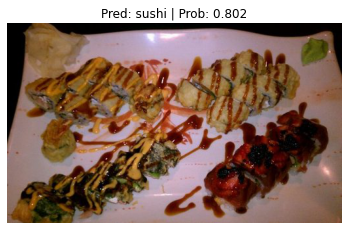

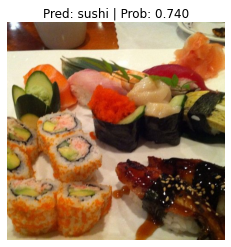

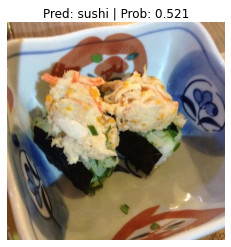

In [41]:
from src.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))

#### Predict on a custom image with the best model

Making predictions on the test dataset is cool but the real magic of machine learning is making predictions on custom images of your own.

So let's import the trusty [pizza dad image](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg) (a photo of my dad in front of a pizza) we've been using for the past couple of sections and see how our model performs on it.

data\04-pizza-dad.jpeg already exists, skipping download.


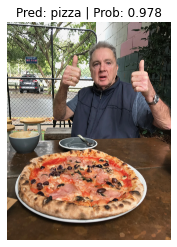

In [42]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)